In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json
from pathlib import Path
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

stemmer = PorterStemmer()
count_vect = CountVectorizer(stop_words='english')  
num_topics = 20
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
nmf = NMF(n_components=num_topics, random_state =42)
lda = LatentDirichletAllocation(n_components=num_topics, random_state =42)

In [2]:
import re
import numpy as np
stemmed_documents = []
stemmed_documents_per_chapter = {}
chapter_topic_probabilities = {}
chapter_topics = {}
counter = 0
with open('../data/chapters/chapter_paragraphs_unmerged.json') as chapter_json:
    chapter_par_dict = json.load(chapter_json)
    counter=len(chapter_par_dict.keys())
    for chapter, pars in chapter_par_dict.items():
        stemmed_documents_per_chapter[chapter] = []
        for par in pars:
            stemmed_par = stemmer.stem(par)
            sent = re.sub('\s+', ' ', stemmed_par)  # remove newline chars
            sent = re.sub('\"', '', sent)  # remove single quotes
            sent = re.sub("\'", '', sent)  # remove single quotes
            words = word_tokenize(sent)
            filtered_sent = [word for word in words if word not in stop_words]
            sent = ' '.join(filtered_sent)
            stemmed_documents.append(sent)
            stemmed_documents_per_chapter[chapter].append(sent)
                
tfidf_chapter = tfidf_vectorizer.fit_transform(stemmed_documents)
features = tfidf_vectorizer.get_feature_names()
# count_chapter = count_vect.fit_transform(
#     stemmed_documents)
# features = count_vect.get_feature_names()
# print(features)
#lda.fit(count_chapter)
nmf.fit(tfidf_chapter)
topics = [[] for i in range(num_topics)]
print(counter)

# for i, topic in enumerate(lda.components_):
#     topics.append([features[i] for i in topic.argsort()[-15:]])
  
nmf_embeddings = nmf.transform(tfidf_chapter)
nmf_embeddings = (nmf_embeddings - nmf_embeddings.mean(axis=0))/nmf_embeddings.std(axis=0)

top_idx = np.argsort(nmf_embeddings,axis=0)[-10:]

for no, idxs in enumerate(top_idx.T): 
    for idx in idxs:
        topics[no].append(stemmed_documents[idx])

# for i, topic in enumerate(nmf.components_):
#     topics.append([features[i] for i in topic.argsort()[-15:]])
    
for i in range(num_topics):
    print(f'Topic #{i}:')
    for topic_desc in topics[i]:
        print(f' ==> {topic_desc}')
        
for chapter, stemmed_pars in stemmed_documents_per_chapter.items():
#     par_mat = count_vect.transform(stemmed_pars)
#     topic_probabilities = lda.transform(par_mat)
    par_mat = tfidf_vectorizer.transform(stemmed_pars)
    topic_probabilities = nmf.transform(par_mat)
    chapter_topic_probabilities[chapter] = {}
    chapter_topics[chapter] = {}
    for i in range(len(stemmed_pars)):
        chapter_topic_probabilities[chapter][i] = list(topic_probabilities[i])
        chapter_topics[chapter][i] = topic_probabilities[i].argmax()

199
Topic #0:
 ==> , said .
 ==> , said .
 ==> , said .
 ==> ? said .
 ==> , said .
 ==> ? said .
 ==> please , said .
 ==> ? said .
 ==> well , said . well , well , well ...
 ==> ? said .
Topic #1:
 ==> ron -- ?
 ==> ron ?
 ==> get , ron !
 ==> ron !
 ==> ron --
 ==> ron --
 ==> ron --
 ==> ron , -- ?
 ==> ron
 ==> ron , !
Topic #2:
 ==> harry --
 ==> harry ?
 ==> harry ! harry ! !
 ==> harry ?
 ==> harry ?
 ==> harry ...
 ==> harry !
 ==> harry ?
 ==> harry , harry , please harry\
 ==> harry !
Topic #3:
 ==> dont -- keep -- dont let --
 ==> b-but d-d-dont --
 ==> dont move !
 ==> -- dont --
 ==> dont --
 ==> still dont --
 ==> dont .
 ==> , dont !
 ==> dont --
 ==> dont --
Topic #4:
 ==> hermione ! hermione !
 ==> hermione .
 ==> hermione --
 ==> hermione !
 ==> hermione ?
 ==> hermione , cant -- ?
 ==> hermione , please --
 ==> hermione !
 ==> hermione --
 ==> hermione ?
Topic #5:
 ==> , said dumbledore .
 ==> , said dumbledore .
 ==> nothing , said dumbledore .
 ==> dumbledore woul

In [3]:
import pandas as pd

columns_ch = ['chapter', 'chapter_no', 'paragraph','topic']
columns_topics = [f'topic_{i}' for i in range(num_topics)]
df = pd.DataFrame(columns=columns_ch+columns_topics)


with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)
idx = 0
for chapter, par_dict in chapter_topic_probabilities.items():
    for par_no, probs in par_dict.items():
        #print(chapter_topics[chapter][par_no])
        df.loc[idx] = [chapter, chapter_numbers[chapter], par_no, chapter_topics[chapter][par_no]] + probs
        idx+=1
        
  

In [4]:
      
df = df.set_index(['chapter_no', 'paragraph']).sort_index()
df

chapter topic   topic_0   topic_1  \
chapter_no paragraph                                                   
0          0             THE BOY WHO LIVED     0  0.000000  0.000000   
           1             THE BOY WHO LIVED     7  0.000519  0.000000   
           2             THE BOY WHO LIVED     7  0.000000  0.000000   
           3             THE BOY WHO LIVED    15  0.000000  0.000000   
           4             THE BOY WHO LIVED    16  0.000378  0.000000   
           5             THE BOY WHO LIVED    16  0.001101  0.000000   
           6             THE BOY WHO LIVED     7  0.000000  0.000000   
           7             THE BOY WHO LIVED    16  0.000000  0.000187   
           8             THE BOY WHO LIVED     7  0.000000  0.000044   
           9             THE BOY WHO LIVED    16  0.000000  0.000412   
           10            THE BOY WHO LIVED     7  0.007390  0.000852   
           11            THE BOY WHO LIVED    16  0.000000  0.000096   
           12            THE BOY WHO LIVED    16  0.000000  0.000359   
           13            THE BOY WHO LIVED    16  0.000886  0.000854   
           14            THE BOY WHO LIVED    11  0.000111  0.000973   
           15            THE BOY WHO LIVED    17  0.002937  0.000000   
           16            THE BOY WHO LIVED     9  0.000000  0.000000   
           17            THE BOY WHO LIVED    19  0.000000  0.000000   
           18            THE BOY WHO LIVED    15  0.000000  0.000350   
           19            THE BOY WHO LIVED    16  0.000000  0.000167   
           20            THE BOY WHO LIVED    16  0.007916  0.000000   
           21            THE BOY WHO LIVED     7  0.000000  0.000000   
           22            THE BOY WHO LIVED    16  0.000000  0.000309   
           23            THE BOY WHO LIVED    16  0.000000  0.000000   
           24            THE BOY WHO LIVED     7  0.024005  0.000000   
           25            THE BOY WHO LIVED    16  0.000000  0.000661   
           26            THE BOY WHO LIVED     7  0.000000  0.000232   
           27            THE BOY WHO LIVED    16  0.000000  0.000000   
           28            THE BOY WHO LIVED     7  0.000000  0.000655   
           29            THE BOY WHO LIVED    13  0.000000  0.000281   
...                                    ...   ...       ...       ...   
198        50         NINETEEN YEARS LATER    11  0.000727  0.000000   
           51         NINETEEN YEARS LATER    16  0.000000  0.000000   
           52         NINETEEN YEARS LATER    12  0.001449  0.000156   
           53         NINETEEN YEARS LATER    16  0.000000  0.000105   
           54         NINETEEN YEARS LATER    16  0.000018  0.000373   
           55         NINETEEN YEARS LATER     0  0.023070  0.000000   
           56         NINETEEN YEARS LATER    16  0.000000  0.000158   
           57         NINETEEN YEARS LATER    13  0.000960  0.000231   
           58         NINETEEN YEARS LATER    16  0.002336  0.001296   
           59         NINETEEN YEARS LATER    16  0.000092  0.000648   
           60         NINETEEN YEARS LATER     3  0.009338  0.000000   
           61         NINETEEN YEARS LATER    13  0.000000  0.000000   
           62         NINETEEN YEARS LATER    16  0.000000  0.000000   
           63         NINETEEN YEARS LATER    16  0.000000  0.000000   
           64         NINETEEN YEARS LATER    16  0.013389  0.000659   
           65         NINETEEN YEARS LATER    16  0.000000  0.000844   
           66         NINETEEN YEARS LATER    16  0.001256  0.000052   
           67         NINETEEN YEARS LATER    13  0.001176  0.000000   
           68         NINETEEN YEARS LATER     2  0.119331  0.000000   
           69         NINETEEN YEARS LATER    16  0.021374  0.000000   
           70         NINETEEN YEARS LATER    16  0.000000  0.000564   
           71         NINETEEN YEARS LATER    16  0.000000  0.002141   
           72         NINETEEN YEARS LATER    13  0.021979  0.051911   
   

<BarContainer object of 20 artists>

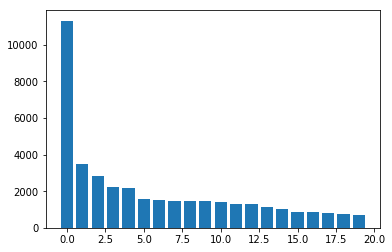

In [18]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

x_axis = np.arange(0, num_topics, 1)
y_axis = df['topic'].value_counts()
plt.bar(x_axis, y_axis)

In [41]:
df.loc[0,:]['topic'].value_counts().idxmax()

16